In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks", {'axes.grid': True})

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

In [3]:
def mono(ticker):
    
    

    # Generate first plot with Weekly Close

    analyzed_stock_daily = yf.Ticker(ticker)

    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    
    daily_closes = analyzed_stock_daily.history(
        period="5y", interval="1d", actions=False).Close
    
    
    daily_vars = daily_closes.pct_change().dropna()
    z_scores_daily = (daily_vars - daily_vars.mean()) / daily_vars.std()
    

    # Generate first plot

    sns.lineplot(daily_closes, ax=ax1)
    ax1.title.set_text('Daily close')
    ax1.tick_params(axis='x', rotation=90)
    

    # Generate second plot with Z-Score

    sns.lineplot(z_scores_daily, ax=ax2)
    ax2.axhline(y=z_scores_daily.mean() + 2 * z_scores_daily.std(),
                color='orange',
                linestyle='--')
    ax2.axhline(y=z_scores_daily.mean() - 2 * z_scores_daily.std(),
                color='orange',
                linestyle='--')
    ax2.title.set_text('Daily Z-Score')
    ax2.tick_params(axis='x', rotation=90)

    fig.suptitle('Plots for ' + ticker)
    
    plt.show()
    

In [4]:
def get_indicator_growth_rate(ticker, indicator='fcf'):
    
    if indicator == 'cash_multiplier':
           
        indicator_values = yf.Ticker(ticker).balancesheet.T[['Cash And Cash Equivalents','Total Debt']]
        indicator_values['cash_multiplier']= indicator_values['Cash And Cash Equivalents']/indicator_values['Total Debt']
        indicator_values = indicator_values['cash_multiplier']
        
        return indicator_values[0] - indicator_values[1]
    
    else:
        if indicator == 'revenue':
            try:
                indicator_values = yf.Ticker(ticker).get_financials().T['TotalRevenue'].values
            
            except:
                    
                indicator_values = "Not Available"
                
        elif indicator == 'ebitda':
            indicator_values = yf.Ticker(ticker).get_financials().T['NormalizedEBITDA'].values
            
        else:
            indicator_values = yf.Ticker(ticker).cash_flow.T['Free Cash Flow'].values
        
        n_periods = len(indicator_values)
        
        if n_periods > 2:
    
            return (indicator_values[0]/indicator_values[-1])**(1/(n_periods-1))-1
        
        else: 
            return "Not Available"
            

In [5]:
def result_metrics(ticker):
    
    
    revenue_growth = get_indicator_growth_rate(ticker,'revenue')
    ebitda_growth = get_indicator_growth_rate(ticker,'ebitda')
    fcf_growth = get_indicator_growth_rate(ticker)
    cash_multiplier = get_indicator_growth_rate(ticker,'cash_multiplier')
    
    
    
    
    
    dict_values = {
                    'Revenue Growth': revenue_growth, 
                   'EBITDA Growth': ebitda_growth, 
                   'FCF Growth': fcf_growth,
                   'Cash Multiplier': cash_multiplier
                   }

    return pd.DataFrame(dict_values, index=[ticker])

In [6]:
def dividend_metrics(ticker):
    analyzed_stock = yf.Ticker(ticker)

    # Payout ratio should be between 30% and 50%
    try:
        payout_ratio = analyzed_stock.info['payoutRatio']
        
    except:
        payout_ratio = "Not Available"

    # I want the dividend median growth rate to be over 3%

    lfy_div = analyzed_stock.dividends.resample('A').sum().tail(5)[:-1]
    median_div_growth = lfy_div.pct_change().dropna().median()

    # I also want the (last) Dividend yield to be less than 5%
    closing_prices = analyzed_stock.history(
        period='6y').Close.resample('A').last()

    df_pre_div_yield = pd.concat([lfy_div, closing_prices], axis=1).dropna()
    
    if len(df_pre_div_yield)>1:
        last_dividend_yield = (df_pre_div_yield.Dividends /df_pre_div_yield.Close).values[-1]

    else:
        last_dividend_yield = "Not Available"

    # The formula is annual dividend per share dividend by free cash flow per share
    # I look for a number below 70%
    try:
        
        last_free_cash_flow = analyzed_stock.cash_flow.T['Free Cash Flow'].head(1).values[0]
        last_dividends_paid = analyzed_stock.cash_flow.T['Cash Dividends Paid'].head(1).values[0]
        free_cash_flow_payout = abs(last_dividends_paid/last_free_cash_flow)
    
    except:
        
        free_cash_flow_payout = "Not Available"

    # I don't want junk
    try:
        quick_ratio = analyzed_stock.info['quickRatio']
    
    except:
        quick_ratio = "Not Available"
        
    # what about last week z_score

    weekly_closes = analyzed_stock.history(
        period="5y", interval="1wk", actions=False).Close

    weekly_change = weekly_closes.pct_change().dropna()

    z_score = (weekly_change - weekly_change.mean())/weekly_change.std()

    dict_values = {'Last Price': analyzed_stock.history(period='1wk', interval='1d').Close[-1],
                   'Payout Ratio': payout_ratio,
                   'Div Growth': median_div_growth,
                   'Dividend Yield': last_dividend_yield,
                   'FCF Payout': free_cash_flow_payout,
                   'Quick Ratio': quick_ratio,
                   'W Z-Score': z_score[-1]}

    return pd.DataFrame(dict_values, index=[ticker])

Keep it simple! This is a god [tweet](https://twitter.com/chin_investor/status/1680786530657521666?s=20) about it!

In [7]:
'''
def f(element):
    try:
        result_metrics(element)
        return True
    except:
        return False
'''

'\ndef f(element):\n    try:\n        result_metrics(element)\n        return True\n    except:\n        return False\n'

In [8]:
result_metrics('RGLD')

,Revenue Growth,EBITDA Growth,FCF Growth,Cash Multiplier
RGLD,0.066864,0.081673,0.307621,0.216026


In [9]:
dividend_metrics('OMC')

,Last Price,Payout Ratio,Div Growth,Dividend Yield,FCF Payout,Quick Ratio,W Z-Score
OMC,94.300003,Not Available,0.0,0.032612,0.418831,Not Available,0.39404


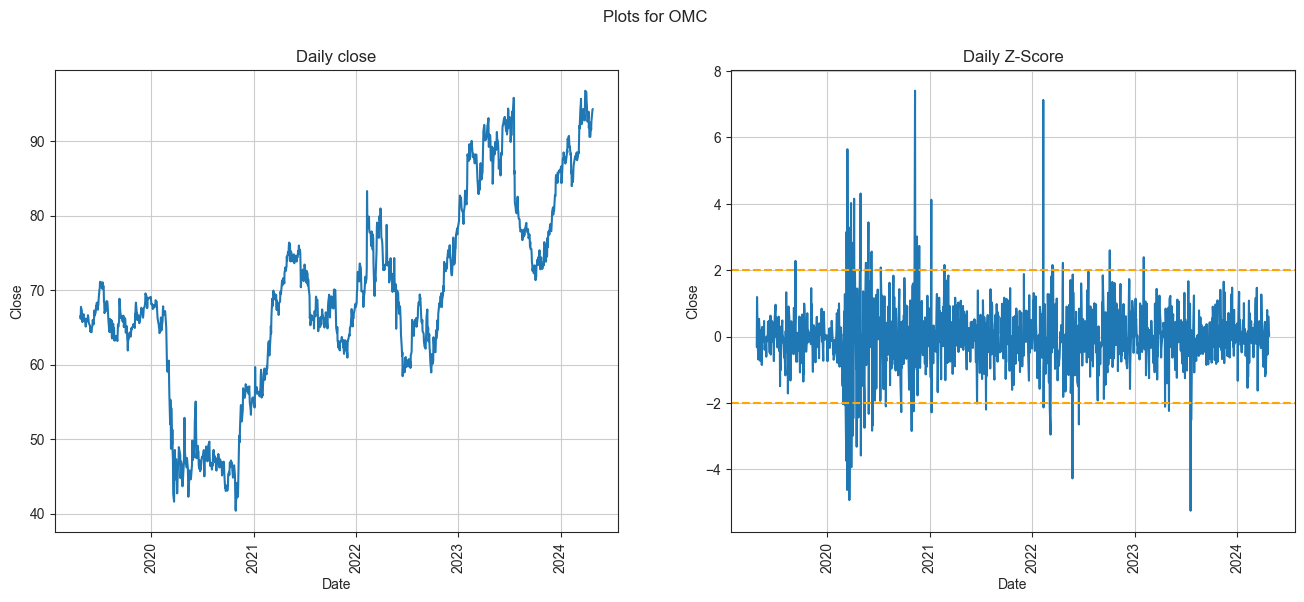

In [10]:
mono('OMC')

In [11]:
def summary (ticker):
    print(result_metrics(ticker))
    print(dividend_metrics(ticker))
    mono(ticker)

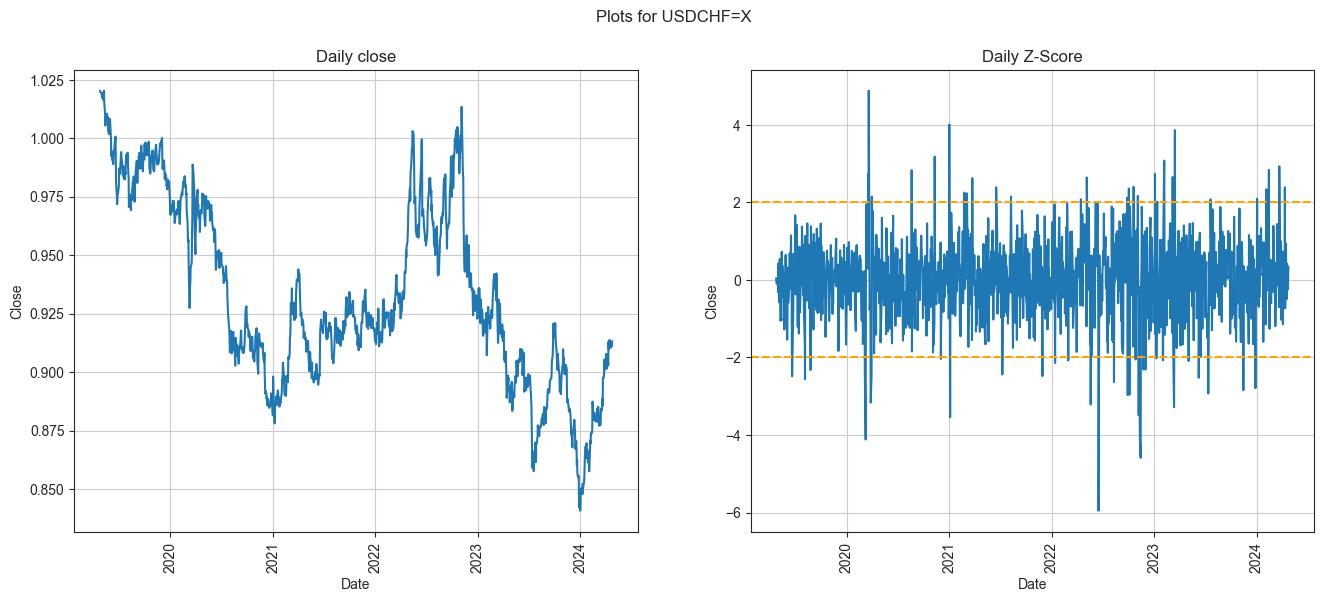

In [12]:
mono('USDCHF=X')

In [13]:
def cash_multiplier_hist(ticker):
        
    indicator_values = yf.Ticker(ticker).balancesheet.T[['Cash And Cash Equivalents','Total Debt']]
    indicator_values['cash_multiplier']= indicator_values['Cash And Cash Equivalents']/indicator_values['Total Debt']
    return indicator_values['cash_multiplier']


In [14]:
cash_multiplier_hist('RIPLEY.SN')

2023-12-31    0.290168
2022-12-31    0.331904
2021-12-31    0.482427
2020-12-31    0.610989
Name: cash_multiplier, dtype: object

In [15]:
cash_multiplier_hist('RIPLEY.SN')[0]-cash_multiplier_hist('RIPLEY.SN')[1]

-0.041736127217049446

In [16]:
get_indicator_growth_rate('PROVIDA.SN')

0.21161968201673265

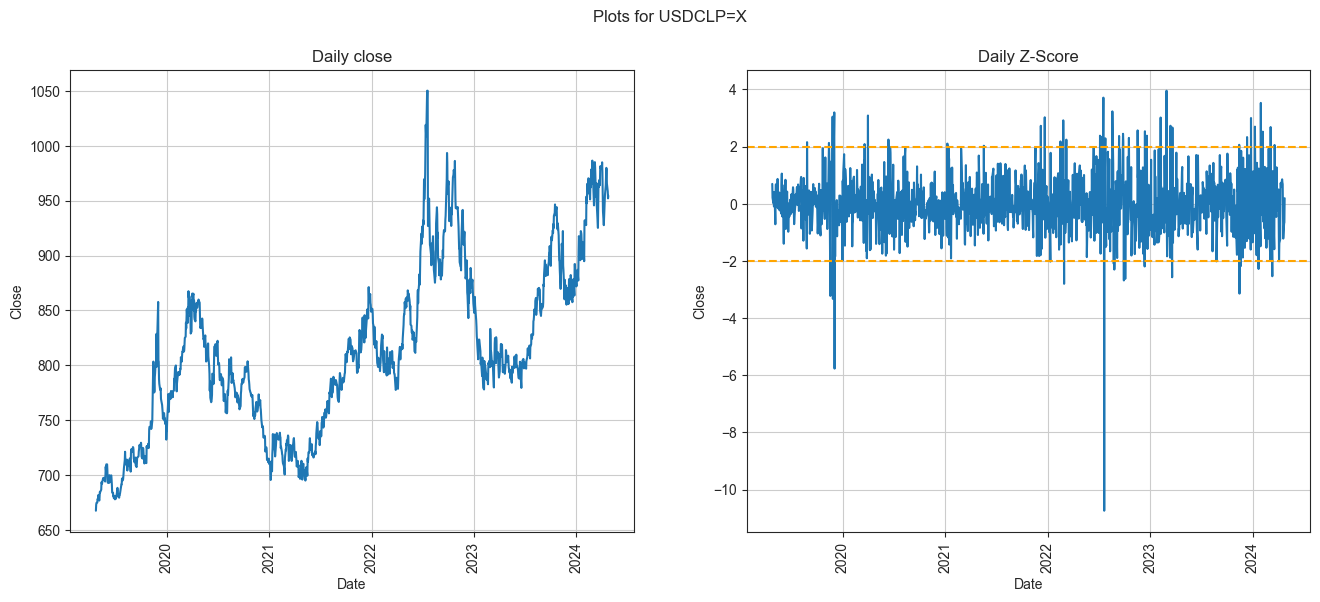

In [17]:
mono('USDCLP=X')

     Revenue Growth  EBITDA Growth  FCF Growth  Cash Multiplier
LKQ        0.060405       0.096518   -0.077439        -0.017615
     Last Price   Payout Ratio  Div Growth  Dividend Yield  FCF Payout  \
LKQ       42.16  Not Available     1.59878        0.023677    0.302605   

       Quick Ratio  W Z-Score  
LKQ  Not Available  -2.554963  


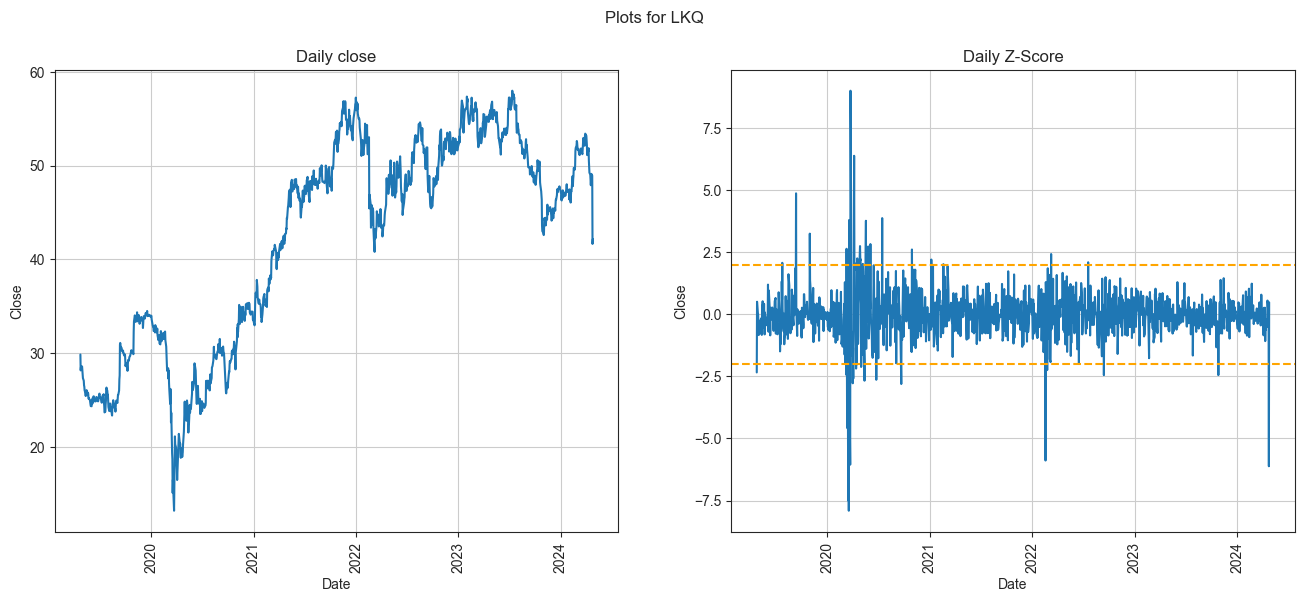

In [18]:
summary('LKQ')